In [2]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import geopandas as gpd
import h3pandas
from h3 import h3
import plotly.figure_factory as ff

PATH_TO_MUTSPEC_META = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/msMetaData.tsv'
PATH_TO_COORDS = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/map_insecta/relevant_coords.tsv'

In [3]:
coords = gpd.read_file(PATH_TO_COORDS)

In [7]:
coords['species'].unique()

2005

In [48]:
coords.geometry.x = coords.decimalLatitude

AttributeError: property 'x' of 'GeoSeries' object has no setter

In [43]:
coords.iloc[[0]].decimalLatitude.to_string().split(' ')[4]

'48.78013'

In [45]:
h3_level = 3

def lat_lng_to_h3(row):
    return h3.geo_to_h3(
      float(row.decimalLatitude.to_string().split(' ')[4]), float(row.decimalLongitude.to_string().split(' ')[4]), h3_level)

coords['h3'] = coords.apply(lat_lng_to_h3(coords.iloc[[0]]), axis=1)

AttributeError: '831f85fffffffff' is not a valid function for 'GeoDataFrame' object

In [8]:
from shapely import geometry


def shift(geom):
    """
    Reads every point in every component of input geometry, and performs the following change:
        if the longitude coordinate is <0, adds 360 to it.
        if the longitude coordinate is >180, subtracts 360 from it.
    Useful for shifting between 0 and 180 centric map
    """

    if geom.is_empty:
        return geom

    if geom.has_z:
        num_dim = 3
    else:
        num_dim = 2

    def shift_pts(pts):
        """Internal function to perform shift of individual points"""
        if num_dim == 2:
            for x, y in pts:
                if x < 0:
                    x += 360
                elif x > 180:
                    x -= 360
                yield (x, y)
        elif num_dim == 3:
            for x, y, z in pts:
                if x < 0:
                    x += 360
                elif x > 180:
                    x -= 360
                yield (x, y, z)

    # Determine the geometry type to call appropriate handler
    if geom.type in ('Point', 'LineString'):
        return type(geom)(list(shift_pts(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(shift_pts(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(shift_pts(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call to shift all components
        return type(geom)([shift(part)
                           for part in geom.geoms])
    else:
        raise ValueError('Type %r not supported' % geom.type)


def idl_resolve(geom, buffer_width=0.0000001):
    """
    Identifies when an intersection is present with -180/180 international date line and corrects it
    Geometry is shifted to 180 centric map and intersection is checked against a line defined as [(180, -90), (180,90)]
    If intersection is identified then the line is buffered by given amount (decimal degrees) and the difference
    between input geometry and buffer result is returned
    If no intersection is identified the passed in geometry is returned
    """

    intersecting_line = geometry.LineString(((180, -90), (180, 90)))
    shifted_geom = shift(geom)

    if shifted_geom.intersects(intersecting_line):
        buffered_line = intersecting_line.buffer(buffer_width)
        difference_geom = shifted_geom.difference(buffered_line)
        geom = shift(difference_geom)

    return geom

In [4]:
coord_df = pd.read_csv(PATH_TO_COORDS, sep='\t')

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs("epsg:4326")
world_cut = world.set_geometry(world.geometry.apply(idl_resolve))

/tmp/ipykernel_7557/2854450847.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_7557/3354936044.py:38: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type in ('Point', 'LineString'):
/tmp/ipykernel_7557/3354936044.py:40: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type == 'Polygon':
/tmp/ipykernel_7557/3354936044.py:47: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geom.type.startswith('Multi') or geom.type 

GEOSException: TopologyException: side location conflict at 53.154927280306119 71.244739214818367. This can occur if the input geometry is invalid.

In [6]:
usa = world[world['iso_a3'] == 'USA']

/home/gabs/.local/lib/python3.11/site-packages/h3pandas/h3pandas.py:751: UserWarning: 46 rows did not generate a H3 cell.Consider using a finer resolution.
  warnings.warn(


<AxesSubplot:>

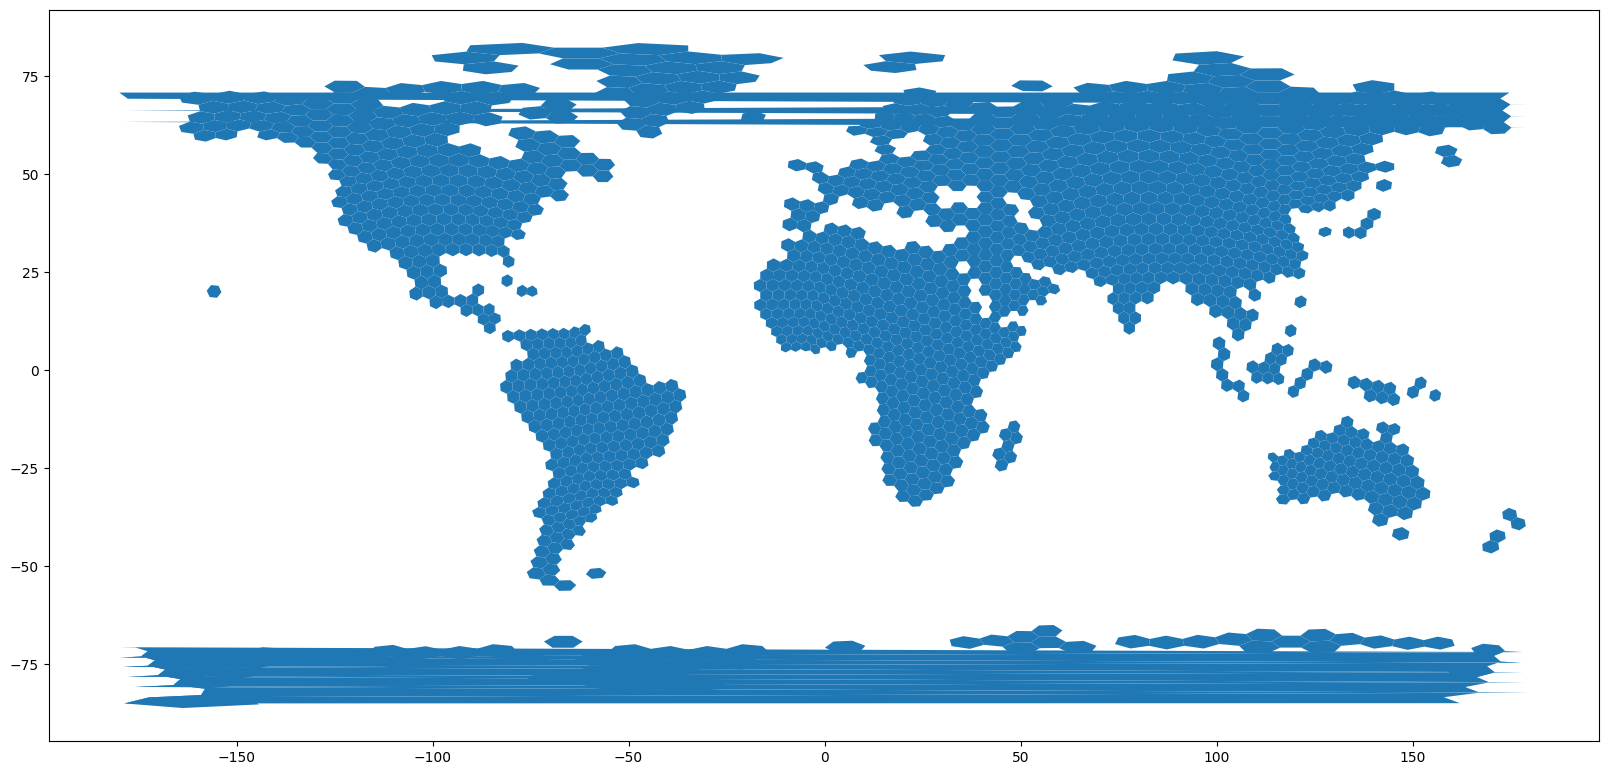

In [20]:
res = 2
hexagons = world.h3.polyfill_resample(res)
hexagons.plot(figsize=(20,10))

In [19]:
fig = px.scatter_geo(coord_df, lat='decimalLatitude', lon='decimalLongitude', color='order',
                     hover_name='species')
fig
